# <center> Image Reconstruction with Autoencoder </center>

___

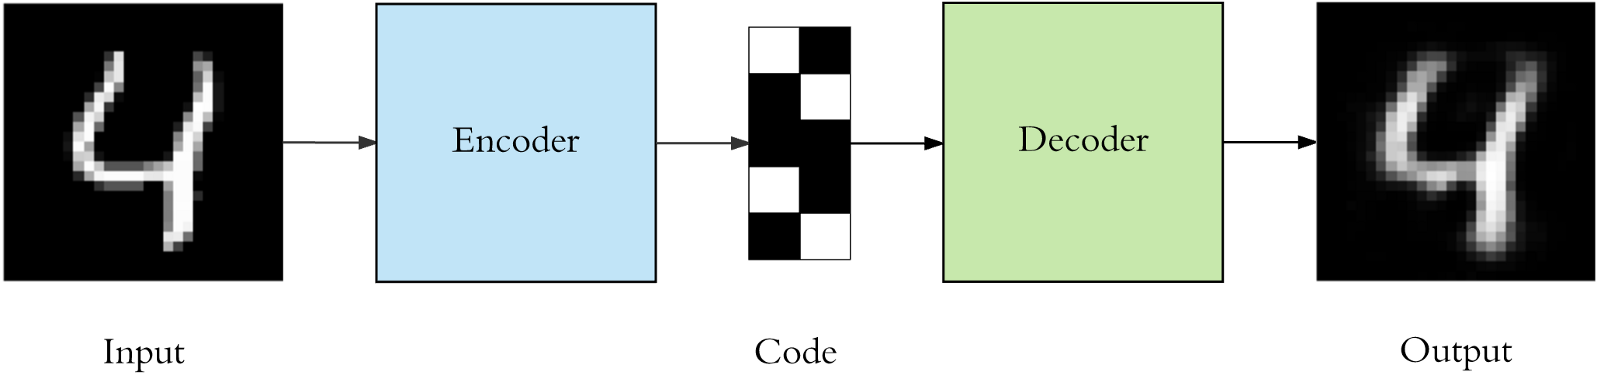

In [1]:
from IPython.display import Image
Image(filename='encodeco.png')

Data Set : MNIST

    Note: Discard the labels

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

Using TensorFlow backend.


Normalize all values between 0 and 1 to converge faster

In [3]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [4]:
print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Flatten the 28x28 images into vectors of size 784.


In [5]:
print('Number of images', x_train.shape[0])
print('Shape of each original image', x_train.shape[1:])
print('Shape of each image after flatten', np.prod(x_train.shape[1:]))

Number of images 60000
Shape of each original image (28, 28)
Shape of each image after flatten 784


In [6]:
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


#### Fully-connected neural layer as encoder and as decoder:

In [7]:
from keras.layers import Input, Dense
from keras.models import Model

In [8]:
# The size of encoded and actual representations
encoding_dim = 32 
actual_dim = x_train.shape[1] #784

In [9]:
# Input placeholder
input_img = Input(shape=(actual_dim,))

# "encoded" is the encoded representation of the input
encoded = Dense(256, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(actual_dim, activation='sigmoid')(encoded)

#### MODEL 1 : Autoencoder

In [10]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [11]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
autoencoder.layers

#### Default values for all biases is zero.

In [13]:
autoencoder.layers[1].get_weights()

[array([[-0.06736396, -0.03587501, -0.05451563, ..., -0.00727481,
         -0.05857794, -0.0079855 ],
        [-0.02712861,  0.06907598, -0.04234545, ..., -0.00435994,
         -0.04037481, -0.07596604],
        [-0.08126637,  0.04936083,  0.03611305, ..., -0.06480247,
          0.06128152, -0.04815968],
        ...,
        [-0.00454573, -0.01722761, -0.04252129, ..., -0.04537706,
          0.04842783,  0.05896819],
        [-0.05151088,  0.00628912,  0.06156423, ...,  0.03015962,
          0.00738304, -0.06730807],
        [-0.03701392, -0.03717222,  0.07586475, ...,  0.06511737,
          0.02099855,  0.03474423]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)]

#### Weights for the connections between input and encoder layer

In [14]:
autoencoder.layers[1].get_weights()[0].shape

(784, 32)

#### Weights for each of the biases for encoder layer

In [15]:
autoencoder.layers[1].get_weights()[1].shape

(32,)

#### MODEL 2 : Encoder only

In [16]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [17]:
print(encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
encoder.layers[1].get_weights()

[array([[-0.06736396, -0.03587501, -0.05451563, ..., -0.00727481,
         -0.05857794, -0.0079855 ],
        [-0.02712861,  0.06907598, -0.04234545, ..., -0.00435994,
         -0.04037481, -0.07596604],
        [-0.08126637,  0.04936083,  0.03611305, ..., -0.06480247,
          0.06128152, -0.04815968],
        ...,
        [-0.00454573, -0.01722761, -0.04252129, ..., -0.04537706,
          0.04842783,  0.05896819],
        [-0.05151088,  0.00628912,  0.06156423, ...,  0.03015962,
          0.00738304, -0.06730807],
        [-0.03701392, -0.03717222,  0.07586475, ...,  0.06511737,
          0.02099855,  0.03474423]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)]

#### MODEL 3 : Decoder only

In [19]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1](encoded_input)

# create the decoder model
decoder = Model(encoded_input, decoder_layer)

In [20]:
print(decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________
None


Configure the model to use a per-pixel binary crossentropy loss, and the Adam optimizer

In [21]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

Train our autoencoder for 50 epochs:

In [22]:
training_history = autoencoder.fit(x_train, x_train, 
                                   epochs=50, batch_size=256, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.2744 - acc: 0.7819 - val_loss: 0.1863 - val_acc: 0.7993
Epoch 2/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.1693 - acc: 0.8029 - val_loss: 0.1528 - val_acc: 0.8050
Epoch 3/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1433 - acc: 0.8074 - val_loss: 0.1325 - val_acc: 0.8082
Epoch 4/50
60000/60000 [==============================] - 3s 49us/step - loss: 0.1276 - acc: 0.8099 - val_loss: 0.1205 - val_acc: 0.8098
Epoch 5/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1178 - acc: 0.8113 - val_loss: 0.1127 - val_acc: 0.8112
Epoch 6/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.1110 - acc: 0.8122 - val_loss: 0.1071 - val_acc: 0.8119
Epoch 7/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.1061 - acc: 0.8128 - val_loss: 0.1028 - val_acc

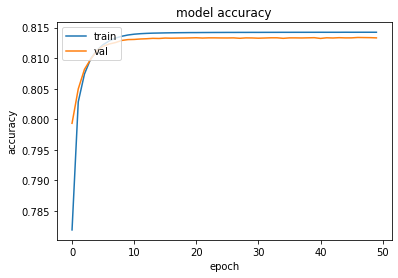

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(training_history.history['acc'])
plt.plot(training_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
autoencoder.layers[1].get_weights()

[array([[-0.06736396, -0.03587501, -0.05451563, ..., -0.00727481,
         -0.05857794, -0.0079855 ],
        [-0.02712861,  0.06907598, -0.04234545, ..., -0.00435994,
         -0.04037481, -0.07596604],
        [-0.08126637,  0.04936083,  0.03611305, ..., -0.06480247,
          0.06128152, -0.04815968],
        ...,
        [-0.00454573, -0.01722761, -0.04252129, ..., -0.04537706,
          0.04842783,  0.05896819],
        [-0.05151088,  0.00628912,  0.06156423, ...,  0.03015962,
          0.00738304, -0.06730807],
        [-0.03701392, -0.03717222,  0.07586475, ...,  0.06511737,
          0.02099855,  0.03474423]], dtype=float32),
 array([ 1.625778  ,  0.4748688 ,  2.7146828 , -0.4267917 , -0.73596746,
        -0.10886835, -0.64236325,  2.8293545 ,  0.04544525,  0.8453137 ,
         1.1852607 ,  0.42680728,  0.17834792,  1.9315214 ,  0.9085154 ,
        -0.65554035,  1.8402225 ,  0.96310514,  2.593361  ,  1.0073117 ,
        -0.764997  ,  2.8452883 , -0.18602666,  2.1430397 , -1.490

In [25]:
encoder.layers[1].get_weights()

[array([[-0.06736396, -0.03587501, -0.05451563, ..., -0.00727481,
         -0.05857794, -0.0079855 ],
        [-0.02712861,  0.06907598, -0.04234545, ..., -0.00435994,
         -0.04037481, -0.07596604],
        [-0.08126637,  0.04936083,  0.03611305, ..., -0.06480247,
          0.06128152, -0.04815968],
        ...,
        [-0.00454573, -0.01722761, -0.04252129, ..., -0.04537706,
          0.04842783,  0.05896819],
        [-0.05151088,  0.00628912,  0.06156423, ...,  0.03015962,
          0.00738304, -0.06730807],
        [-0.03701392, -0.03717222,  0.07586475, ...,  0.06511737,
          0.02099855,  0.03474423]], dtype=float32),
 array([ 1.625778  ,  0.4748688 ,  2.7146828 , -0.4267917 , -0.73596746,
        -0.10886835, -0.64236325,  2.8293545 ,  0.04544525,  0.8453137 ,
         1.1852607 ,  0.42680728,  0.17834792,  1.9315214 ,  0.9085154 ,
        -0.65554035,  1.8402225 ,  0.96310514,  2.593361  ,  1.0073117 ,
        -0.764997  ,  2.8452883 , -0.18602666,  2.1430397 , -1.490

We can see after training the biases have changed and they are same for autoencoder and encoder model. The reamining parameters didn't seem to have changed.

Visualize the reconstructed inputs and the encoded representations using Matplotlib.

In [26]:
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)

decoded_imgs = decoder.predict(encoded_imgs)

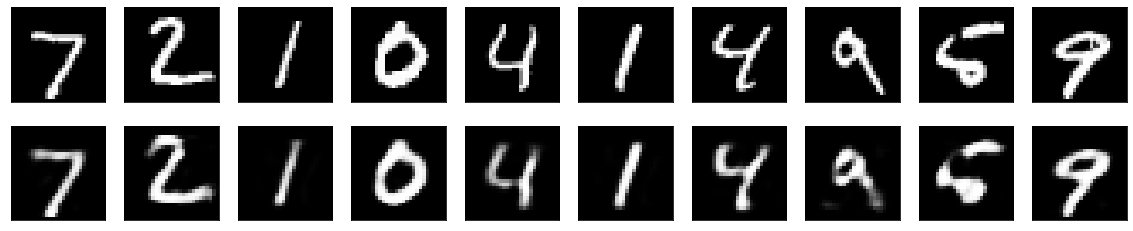

In [27]:
# use Matplotlib 
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Ref:

    https://blog.keras.io/building-autoencoders-in-keras.html